In [1]:
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor, Normalize, Compose
from torch.utils.data import DataLoader, random_split
from torch.optim import Adam
from bbb import BayesMLP, ClassificationELBOLoss
import torch
import numpy as np
import random
from utils import evaluate_bbb as evaluate, rotate, grid_show_imgs

torch.manual_seed(0)
np.random.seed(0)
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'


data_dir = '~/datasets'
batch_size = 128
sample_num = 5

In [2]:
# ===== 数据准备
full_ds = MNIST(data_dir, train=True, download=True, 
                transform=Compose([ToTensor(), Normalize((0.1307,), (0.3081,))]))
train_ds, val_ds = random_split(full_ds, [55000, 5000])

test_ds = MNIST(data_dir, train=False, download=True, 
                transform=Compose([ToTensor(), Normalize((0.1307,), (0.3081,))]))
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

in_dim = train_ds[0][0].numel() # 输入维度
out_dim = 10                    # 输入维度
batch_num=len(train_dl)         # 小批量总数

In [3]:
# ===== 模型定义
# 模型
model = BayesMLP(in_dim, out_dim, hidden_dims=[128, 64]).to(device)
# 优化器
opt = Adam(model.parameters(), lr=0.001)
# 损失
loss_fn = ClassificationELBOLoss(batch_num=batch_num)

In [4]:
# ===== 训练
epochs = 3
for epoch in range(epochs):                                                         # 算法2：第2行
    for batch, (batch_x, batch_y) in enumerate(train_dl):
        opt.zero_grad()
        model_out = model(batch_x, sample_num)
        loss = loss_fn(model_out, batch_y)
        loss.backward()                                                             # 算法2：第9行
        opt.step()                                                                  # 第法2：第12行
        if batch % 100 == 0:
            acc = evaluate(model, val_dl, sample_num)
            print(f'epoch: {epoch+1:>2}/{epochs:<2} batch: {batch+1:>4}/{batch_num:<4} '
                  f'Loss: {loss.item():.8}\tValid Acc: {acc: .6}')
            model.train()

epoch:  1/3  batch:    1/430  Loss: 1514.616	Valid Acc:  0.1146
epoch:  1/3  batch:  101/430  Loss: 1224.0913	Valid Acc:  0.8882
epoch:  1/3  batch:  201/430  Loss: 1206.0056	Valid Acc:  0.9138
epoch:  1/3  batch:  301/430  Loss: 1158.5725	Valid Acc:  0.9252
epoch:  1/3  batch:  401/430  Loss: 1151.0861	Valid Acc:  0.933
epoch:  2/3  batch:    1/430  Loss: 1133.4948	Valid Acc:  0.937
epoch:  2/3  batch:  101/430  Loss: 1115.9657	Valid Acc:  0.9414
epoch:  2/3  batch:  201/430  Loss: 1096.7395	Valid Acc:  0.9452
epoch:  2/3  batch:  301/430  Loss: 1070.5167	Valid Acc:  0.9456
epoch:  2/3  batch:  401/430  Loss: 1056.264	Valid Acc:  0.9524
epoch:  3/3  batch:    1/430  Loss: 1043.6096	Valid Acc:  0.9504
epoch:  3/3  batch:  101/430  Loss: 1032.6469	Valid Acc:  0.95
epoch:  3/3  batch:  201/430  Loss: 1015.1408	Valid Acc:  0.9562
epoch:  3/3  batch:  301/430  Loss: 1013.5477	Valid Acc:  0.9576
epoch:  3/3  batch:  401/430  Loss: 981.62958	Valid Acc:  0.9554


In [5]:
# ==== 测试、可视化
test_acc = evaluate(model, test_dl, sample_num)
print(f"Test acc: {test_acc:.6}")

Test acc: 0.961


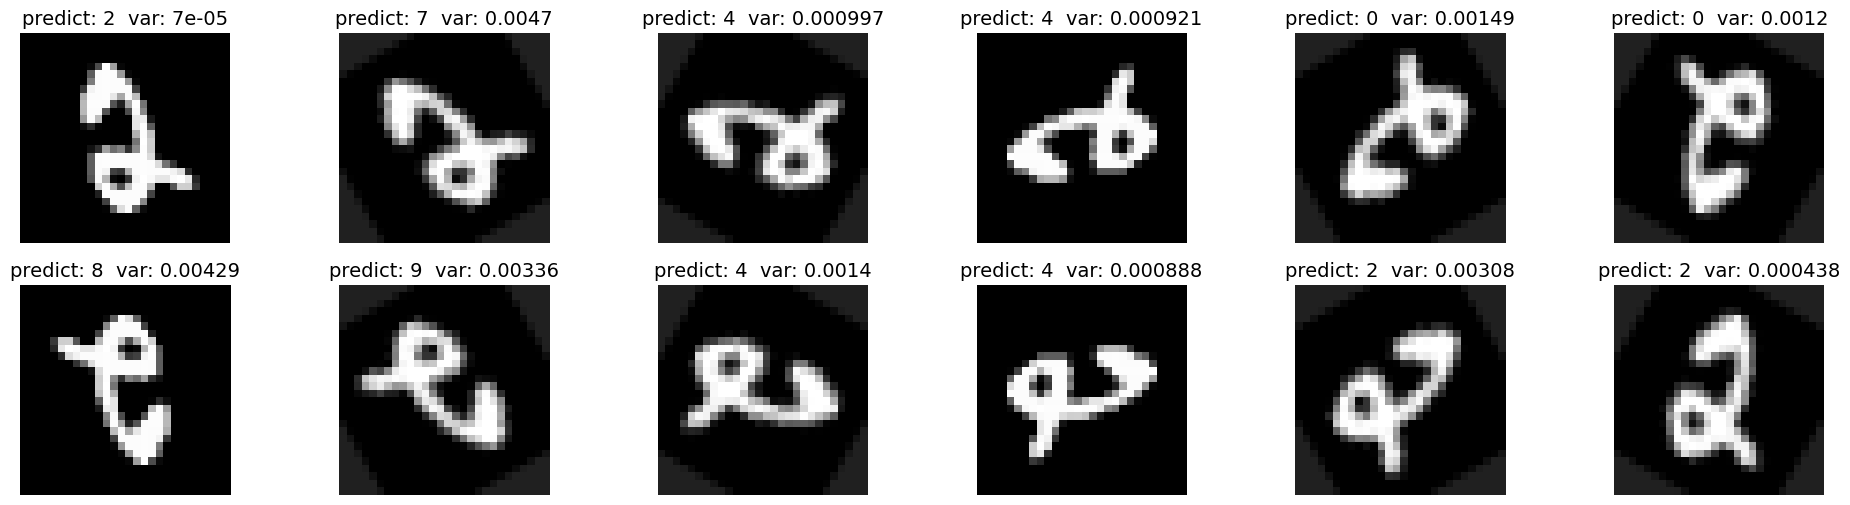

In [6]:
# 从测试集中随机选择一个数据
img = random.choice(test_ds)
imgs = rotate(img[0], angle=30)                         # 旋转图像
model.eval()
preds = model(imgs, sample_num=50)                      # 多次采样
preds = torch.stack(preds, dim=-1).softmax(dim=1)
mean_preds = preds.mean(dim=-1).argmax(dim=1)           # 预测的均值
preds_var = preds.var(dim=-1).mean(dim=1)               # 预测的方差

infos = [f'predict: {p.item()}  var: {v.item():.3}' for p, v in zip(mean_preds, preds_var)]
grid_show_imgs(imgs, infos=infos)